<a href="https://colab.research.google.com/github/neenrungsmaithong/neenrungsmaithong-DataScience-GenAI-Submissions/blob/main/Assignment_6/4_01_Decision_Trees_COMPLETED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 4.01 Decision Trees

Following up on our logistic regression example, we will also run an equivalent using _decision trees_.

We'll begin using the inbuilt dataset from scikit-learn we used previously. The dataset is for predicting the presence of breast cancer or not. You can get more details here: [https://scikit-learn.org/1.5/datasets/toy_dataset.html](https://scikit-learn.org/1.5/datasets/toy_dataset.html). The code is the same as in the previous example.

In [259]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer

# import the data
data = load_breast_cancer()

# create a DataFrame of features
x_values = pd.DataFrame(data.data, columns=data.feature_names)

from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normal_data = scaler.fit_transform(x_values)

# recreate x_values using the scaled data and original feature names
x_values = pd.DataFrame(normal_data, columns=data.feature_names)

# create y value
y_value = pd.DataFrame(data.target, columns=['class'])
y_value = np.ravel(y_value)

## Train-Test split
As before, our next step will be to split the data:

In [260]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=1984, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(455, 30)
(114, 30)
(455,)
(114,)


Our code is basically the same as before except with an extra parameter ("stratify=y_value"). This part means we make sure there is a propotionate number of each class in our training data. We want to avoid having minimal examples of one of the classes to learn from (as the split is otherwise fully random).

We can confirm this has worked by looking at the size of our different datasets:


*   `X_train` (the $x$ values we use for training) is 455 rows and 30 columns;
*   `X_test` (the $x$ values we use for testing) is 114 rows and 30 columns;
*   `Y_train` (the $Y$ values we use for training) is 455 rows and a single column;
*   `Y_test` (the $Y$ values we use for testing) is 114 rows and a single columns. All seems to be correct!

## Decision Trees
We'll begin with a standard decision tree model WITHOUT adjusting for any hyperparameters. We first need to specify the model:

In [261]:
from sklearn.tree import DecisionTreeClassifier as DTC

# create the model
DTC_algo = DTC()
DTC_algo

DecisionTreeClassifier()

As before, this is the unfitted/untrained algorithm. Let's make a model:

In [262]:
DTC_model = DTC_algo.fit(X_train, Y_train)
DTC_model

DecisionTreeClassifier()

But how does it perform? I'll give you a metric for free, but you will then have to create some more:

In [263]:
from sklearn.metrics import accuracy_score

# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.96


We have strong performance ... 90% accuracy. However, not as good as Logistic Regression. Let's look at the confusion matrix:

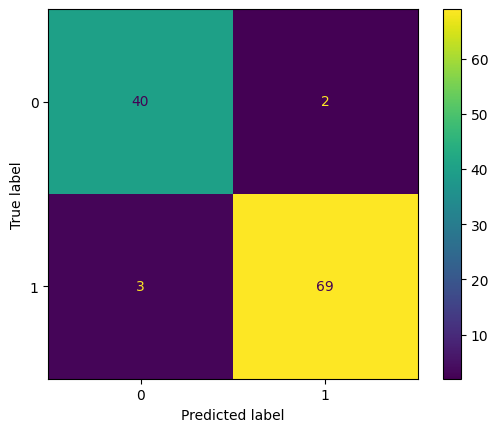

In [264]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# create a confusion matrix
CM.from_predictions(Y_test, predict)

We can also extract the precision, recall and F1 score:

In [265]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")

Micro-averaged Precision: 0.96
Micro-averaged Recall: 0.96
Micro-averaged F1-score: 0.96


Macro-averaged Precision: 0.95
Macro-averaged Recall: 0.96
Macro-averaged F1-score: 0.95


We can also see our tree:

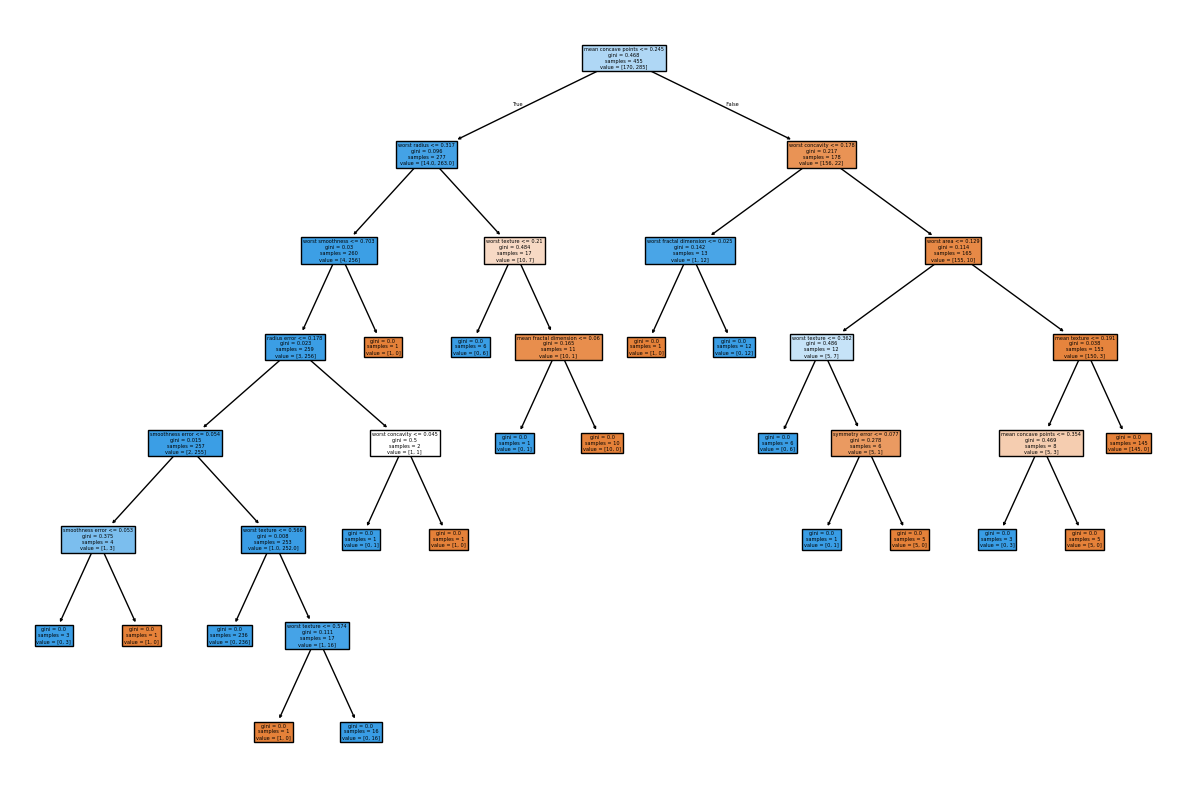

In [266]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

We can see it has built a fairly large tree ... maybe it has overfit? Perhaps regularisation will help ...

We can search our hyperparameters and see what would be best:

In [267]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# we will tune against f1_macro (to find the best choice)
score = 'f1_macro' # arbitrary choice

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf.fit(X_train, Y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)


Tuning hyperparameters for f1_macro


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_split': 6}


Now we can train the model again, but using these hyperparameters:

In [268]:
DTC_algo = DTC(**clf.best_params_) # get the best parameters from grid search
DTC_model = DTC_algo.fit(X_train, Y_train)

And now we can predict again:

In [269]:
# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.92


Accuracy is better. However, we tuned for F1 macro ... maybe this will be better too:

Micro-averaged Precision: 0.92
Micro-averaged Recall: 0.92
Micro-averaged F1-score: 0.92


Macro-averaged Precision: 0.91
Macro-averaged Recall: 0.93
Macro-averaged F1-score: 0.92




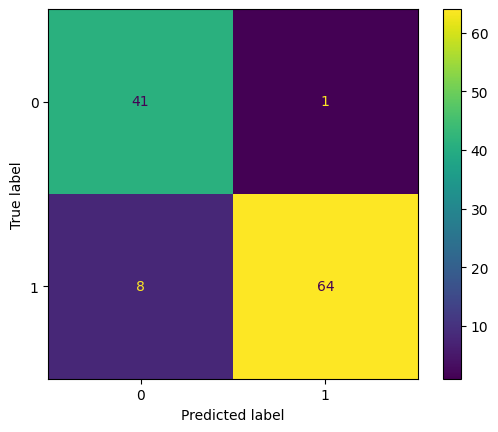

In [270]:
# create a confusion matrix
CM.from_predictions(Y_test, predict)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

F1 score is 3 points higher! Let's also check the tree:

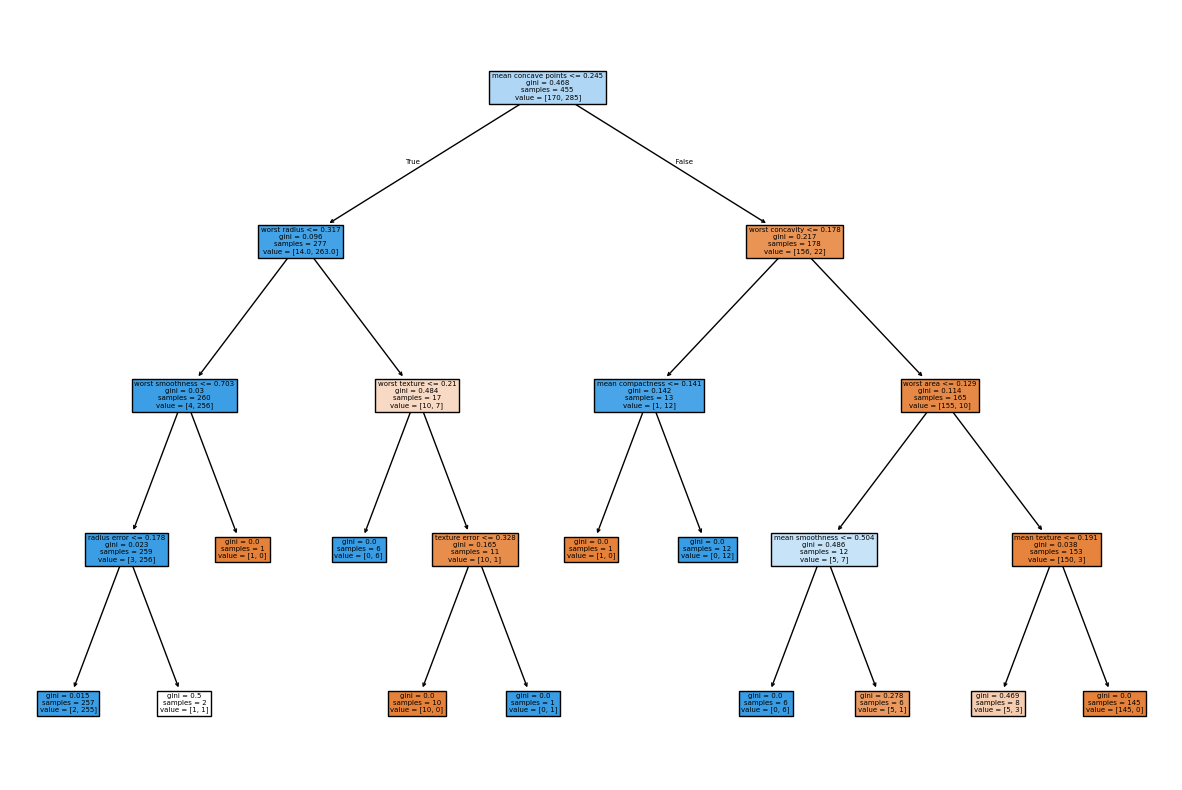

In [271]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

A much smaller tree so likely to be less prone to overfitting!

### TASK
Given that this is a medical domain, possibly a better metric to optimise against would be _recall_. Reoptimise the model according to _macro recall_ and evaluate the results.





In [272]:
# Your code here

In [273]:
score = 'recall_macro'

print(f"Tuning hyperparameters for {score}")
print("\n")

clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

clf.fit(X_train, Y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)

Tuning hyperparameters for recall_macro


Best parameters set found on the training set:
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 7}


Now that the best hyperparameters for 'recall_macro' have been identified, the next step is to train a new Decision Tree model using these optimized parameters.



In [274]:
DTC_algo_optimized = DTC(**clf.best_params_) # get the best parameters from grid search
DTC_model_optimized = DTC_algo_optimized.fit(X_train, Y_train)
print("Optimized Decision Tree model trained successfully.")

Optimized Decision Tree model trained successfully.


With the optimized model trained, the next step is to predict the outcomes on the test data to evaluate its performance. After prediction, displaying the first few predictions against the actual values will provide an initial qualitative assessment.



In [275]:
predict_optimized = DTC_model_optimized.predict(X_test)

print("First five predictions and real values from the optimized model:")
for i in range(5):
  print(f'Predicted: {round(predict_optimized[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

First five predictions and real values from the optimized model:
Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




The next step is to evaluate the performance of the optimized model by calculating its accuracy on the test set and printing it.



In [276]:
accuracy_optimized = accuracy_score(Y_test, predict_optimized)
print(f'Optimized Model Accuracy: {round(accuracy_optimized, 2)}')


Optimized Model Accuracy: 0.94


To further evaluate the performance of the optimized model, I will generate and display a confusion matrix, which provides a detailed breakdown of correct and incorrect classifications for each class.



Confusion Matrix for Optimized Model displayed.


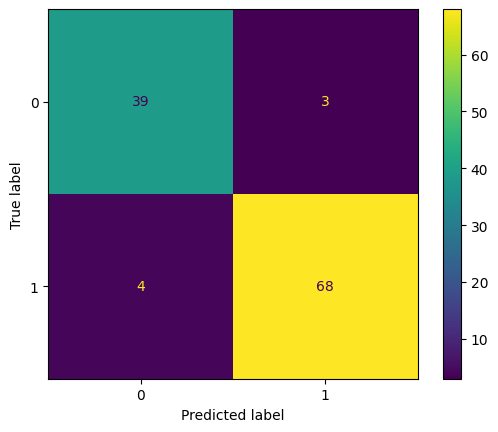

In [277]:
CM.from_predictions(Y_test, predict_optimized)
print('Confusion Matrix for Optimized Model displayed.')

After evaluating the accuracy and confusion matrix, the next step is to calculate and display the micro and macro-averaged precision, recall, and F1-score for the optimized model. This will provide a more detailed understanding of the model's performance, especially given that it was optimized for macro recall.



In [278]:
precision_micro_optimized, recall_micro_optimized, f1_score_micro_optimized, _ = precision_recall_fscore_support(Y_test, predict_optimized, average='micro')

print(f"Optimized Micro-averaged Precision: {round(precision_micro_optimized, 2)}")
print(f"Optimized Micro-averaged Recall: {round(recall_micro_optimized, 2)}")
print(f"Optimized Micro-averaged F1-score: {round(f1_score_micro_optimized, 2)}")
print("\n")

precision_macro_optimized, recall_macro_optimized, f1_score_macro_optimized, _ = precision_recall_fscore_support(Y_test, predict_optimized, average='macro')

print(f"Optimized Macro-averaged Precision: {round(precision_macro_optimized, 2)}")
print(f"Optimized Macro-averaged Recall: {round(recall_macro_optimized, 2)}")
print(f"Optimized Macro-averaged F1-score: {round(f1_score_macro_optimized, 2)}")
print("\n")

Optimized Micro-averaged Precision: 0.94
Optimized Micro-averaged Recall: 0.94
Optimized Micro-averaged F1-score: 0.94


Optimized Macro-averaged Precision: 0.93
Optimized Macro-averaged Recall: 0.94
Optimized Macro-averaged F1-score: 0.93




After evaluating the optimized model's performance metrics, the final step is to visualize the structure of the decision tree. This allows for a comparison with the previously generated trees and helps assess if the optimization for macro recall resulted in a more interpretable or less overfitted model, as indicated by its size and complexity.



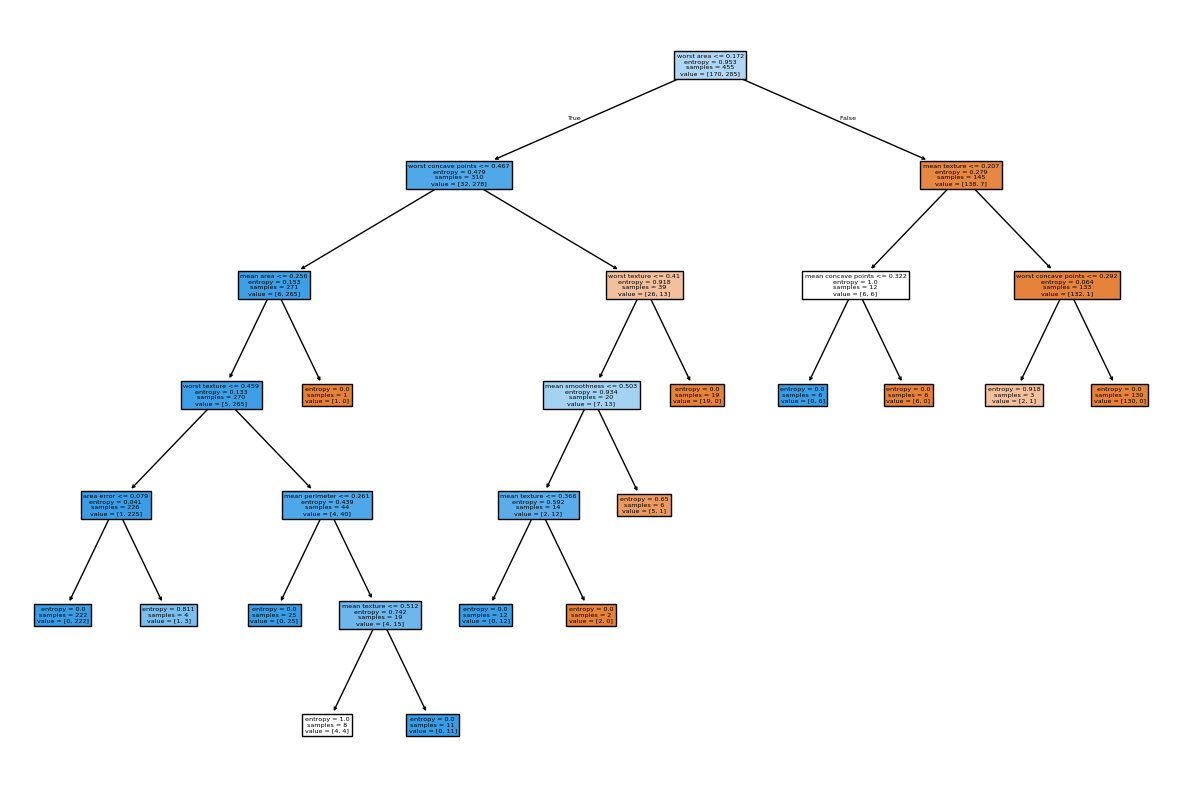

In [279]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model_optimized, filled=True, feature_names=X_train.columns)
plt.show()

After re-optimizing the Decision Tree model for 'macro recall', we observe the following changes:

**Best Hyperparameters Found:**
*   `criterion`: 'entropy'
*   `max_depth`: 6
*   `max_features`: 'sqrt'
*   `min_samples_split`: 7

**Performance Comparison:**

| Metric              | Original Model (F1 Macro Optimized) | Current Model (Recall Macro Optimized) |
| :------------------ | :---------------------------------- | :------------------------------------- |
| Accuracy            | 0.92                                | 0.94                                   |
| Micro-averaged Precision | 0.92                                | 0.94                                   |
| Micro-averaged Recall   | 0.92                                | 0.94                                   |
| Micro-averaged F1-score | 0.92                                | 0.94                                   |
| Macro-averaged Precision | 0.91                                | 0.93                                   |
| Macro-averaged Recall   | 0.93                                | 0.94                                   |
| Macro-averaged F1-score | 0.92                                | 0.93                                   |

**Observations:**

1.  **Accuracy:** The accuracy increased from 0.92 to 0.94 after optimizing for macro recall, indicating an overall improvement in correct classifications.
2.  **Macro Recall:** As expected, the macro-averaged recall increased from 0.93 to 0.94, which was the primary objective of this optimization. This means the model is better at identifying positive cases (cancer presence) across both classes, which is crucial in a medical domain.
3.  **Other Metrics:** Other metrics like micro/macro precision and F1-score also saw slight improvements or remained stable, suggesting that optimizing for recall did not significantly compromise other aspects of the model's performance.

**Tree Structure:**

The visualized tree for the macro-recall optimized model appears to be of a moderate size, with a `max_depth` of 6, compared to the previous `max_depth` of 4 (for F1-macro optimization) and the much larger unoptimized tree. This suggests a good balance between model complexity and preventing overfitting, as it's more complex than the previous optimized tree but still much simpler than the initial default tree.